In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Bio.UniProt.GOA import GAF20FIELDS
import pandas as pd
from tqdm import tqdm

# Download required files. 

In [8]:
#Gene ontology
!wget -nc -O data/go.obo "http://purl.obolibrary.org/obo/go/go-basic.obo"

--2021-08-19 23:46:21--  http://purl.obolibrary.org/obo/go/go-basic.obo
Resolving purl.obolibrary.org (purl.obolibrary.org)... 52.3.123.63
Connecting to purl.obolibrary.org (purl.obolibrary.org)|52.3.123.63|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://current.geneontology.org/ontology/go-basic.obo [following]
--2021-08-19 23:46:22--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontology.org)... 99.84.232.231, 99.84.232.35, 99.84.232.185, ...
Connecting to current.geneontology.org (current.geneontology.org)|99.84.232.231|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30897160 (29M) [text/obo]
Saving to: ‘data/go.obo’

data/go.obo         100%[===================>]  29.47M  70.2MB/s    in 0.4s    

2021-08-19 23:46:22 (70.2 MB/s) - ‘data/go.obo’ saved [30897160/30897160]



In [7]:
#Gene Ontology Annotations (2021 April)
!wget -nc -O data/goa.gaf.gz "ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/old//UNIPROT/goa_uniprot_all.gaf.203.gz"

--2021-08-19 23:35:37--  ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/old//UNIPROT/goa_uniprot_all.gaf.203.gz
           => ‘data/goa.gaf.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/GO/goa/old//UNIPROT ... done.
==> SIZE goa_uniprot_all.gaf.203.gz ... 13749964119
==> PASV ... done.    ==> RETR goa_uniprot_all.gaf.203.gz ... done.
Length: 13749964119 (13G) (unauthoritative)

goa_uniprot_all.gaf 100%[===================>]  12.80G  20.5MB/s    in 10m 42s 

2021-08-19 23:46:21 (20.4 MB/s) - ‘data/goa.gaf.gz’ saved [13749964119]



In [4]:
#Swissprot proteins
!mkdir data
!wget -nc -O data/swissprot.tar.gz "https://ftp.uniprot.org/pub/databases/uniprot/previous_major_releases/release-2021_02/knowledgebase/uniprot_sprot-only2021_02.tar.gz"
!mkdir data/swissprot && cd data/swissprot && tar -zxvf ../swissprot.tar.gz && cd ..

--2021-08-19 23:33:15--  https://ftp.uniprot.org/pub/databases/uniprot/previous_major_releases/release-2021_02/knowledgebase/uniprot_sprot-only2021_02.tar.gz
Resolving ftp.uniprot.org (ftp.uniprot.org)... 128.175.240.195
Connecting to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1491395408 (1.4G) [application/x-gzip]
Saving to: ‘data/swissprot.tar.gz’

data/swissprot.tar. 100%[===================>]   1.39G  28.6MB/s    in 56s     

2021-08-19 23:34:12 (25.4 MB/s) - ‘data/swissprot.tar.gz’ saved [1491395408/1491395408]

uniprot_sprot.dat.gz
uniprot_sprot.fasta.gz
uniprot_sprot_varsplic.fasta.gz
uniprot_sprot.xml.gz


In [11]:
import gzip
from Bio import SeqIO
#Filter GOA annotations to SwissProt proteins. 
with gzip.open('data/swissprot/uniprot_sprot.fasta.gz', 'rt') as fp:
    seq_ids = set(map(lambda rec: rec.id.split('|')[1], SeqIO.parse(fp, 'fasta')))
                      

In [15]:
#Subsample relevant rows of GOA. 
df_iter = pd.read_csv('data/goa.gaf.gz', dtype=str,
                      sep='\t',
                      comment='!',
                      names=GAF20FIELDS,
                      chunksize=int(1e6))

for zdf in tqdm(df_iter, desc='Parsing GOA for SwissProt'):
    # For now, remove all with a qualifier
    zdf = zdf[zdf.DB_Object_ID.isin(seq_ids)]
    zdf.to_csv('data/swissprot_goa.gaf', mode='a', sep='\t', na_rep='', header=False)

Parsing GOA for SwissProt: 953it [1:02:26,  3.93s/it]


In [16]:
!gzip data/swissprot_goa.gaf

In [35]:
from go_bench.utils import exp_group

prot_id_sets = ("training", "validation", "testing")
prot_id_dict = {}
split_path = "data/data_splits/cluster50"
for set_type in prot_id_sets:
    with open(f"{split_path}/{set_type}_ids.txt", "r") as f:
        prot_id_dict[set_type] = set(x[:-1] for x in f.readlines())
        
#Convert swissprot dataframe into training set for BLAST. 
swissprot_df = pd.read_csv('data/swissprot_goa.gaf.gz',
                          sep='\t',
                          comment='!',
                          names=GAF20FIELDS)

EXP_EVIDENCE = set(exp_group)
training_set = prot_id_dict['training']
neg_qualifiers = {q for q in set(swissprot_df.Qualifier) if "NOT" in q or "negative" in q}
swissprot_df = swissprot_df[swissprot_df.DB_Object_ID.isin(training_set) & swissprot_df.Evidence.isin(EXP_EVIDENCE) & ~swissprot_df.Qualifier.isin(neg_qualifiers)]
blast_fmt_ann = swissprot_df[['DB_Object_ID', 'GO_ID']].copy()
blast_fmt_ann.to_csv("data/cluster50_blast_fmt_ann.tab", sep='\t', index=False, header=False)

In [173]:
all_prot_ids = set()
t = 0
for d in prot_id_dict.values():
    print(len(d))
    t += len(d)
    all_prot_ids.update(d)
print(len(all_prot_ids), t)

373506
80027
79976
533509 533509


In [38]:
from goatools.obo_parser import GODag
from go_bench.pipeline import pipeline
import os
godag = GODag('data/go.obo')

data/go.obo: fmt(1.2) rel(2021-07-02) 47,229 GO Terms


In [1]:
from go_bench.utils import exp_group, non_iea_group, all_group, namespaces

In [ ]:
#Make training, validation, and testing sets
goa_path = "data/swissprot_goa.gaf.gz"
split_path = "data/data_splits/cluster50"

In [57]:
from go_bench.utils import exp_group, exp_phy_ht_group, non_iea_group, all_group
for g in [exp_group, exp_phy_ht_group, non_iea_group, all_group]:
    pa_dict = load_protein_annotations(goa_path, g)
    print(len(pa_dict))

77447
130836
146008
542641


In [3]:
print(exp_group, non_iea_group, all_group)

('EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP', 'TAS', 'IC') ('EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP', 'TAS', 'IC', 'HTP', 'HDA', 'HMP', 'HGI', 'HEP', 'IBA', 'IBD', 'IKR', 'IRD', 'ISS', 'ISO', 'ISA', 'ISM', 'IGC', 'RCA') ('ISO', 'IGI', 'ISA', 'IGC', 'IEP', 'RCA', 'HDA', 'HGI', 'IKR', 'TAS', 'HEP', 'ND', 'IBA', 'IMP', 'EXP', 'IDA', 'IC', 'ISM', 'ISS', 'NAS', 'IRD', 'IEA', 'IPI', 'HMP')


In [78]:
save_dir = "datasets/exp"
if(not os.path.isdir(save_dir)):
    os.makedirs(save_dir) 
pipeline(goa_path, split_path, save_dir, godag, codes=exp_group)

loading annotations
initial len 485514
filtering annotations to godag
filtered len 485083
propogating annotations
propogated len 3163432
getting counts
generating datasets
12188 terms in molecular_function
filtering namespace: molecular_function
filtered_list length 427
prot_ids: 373506
saving results
saving to training_data/exp/training_molecular_function_annotations.tsv
training_data/exp/training_molecular_function_annotations.tsv 77444 373506 427
prot_ids: 80027
saving results
saving to training_data/exp/validation_molecular_function_annotations.tsv
training_data/exp/validation_molecular_function_annotations.tsv 77444 80027 427
testing list length 6778
prot_ids: 79976
saving results
saving to training_data/exp/testing_molecular_function_annotations.tsv
training_data/exp/testing_molecular_function_annotations.tsv 77444 79976 6778
30633 terms in biological_process
filtering namespace: biological_process
filtered_list length 2218
prot_ids: 373506
saving results
saving to training_data/

In [80]:
ann_groups = [exp_group, non_iea_group, all_group]
ann_names = ["exp", "non_IEA", "all"]
for g_name, g in zip(ann_names, ann_groups):
    save_dir = f"datasets/{g_name}"
    if(not os.path.isdir(save_dir)):
        os.makedirs(save_dir) 
    pipeline(goa_path, split_path, save_dir, godag, codes=g, filter_type=('min_samples', 100))

loading annotations
initial len 485514
filtering annotations to godag
filtered len 485083
propogating annotations
propogated len 3163432
getting counts
generating datasets
12188 terms in molecular_function
filtering namespace: molecular_function
filtered_list length 427
prot_ids: 373506
saving results
saving to training_data/exp/training_molecular_function_annotations.tsv
training_data/exp/training_molecular_function_annotations.tsv 77444 373506 427
prot_ids: 80027
saving results
saving to training_data/exp/validation_molecular_function_annotations.tsv
training_data/exp/validation_molecular_function_annotations.tsv 77444 80027 427
testing list length 6778
prot_ids: 79976
saving results
saving to training_data/exp/testing_molecular_function_annotations.tsv
training_data/exp/testing_molecular_function_annotations.tsv 77444 79976 6778
30633 terms in biological_process
filtering namespace: biological_process
filtered_list length 2218
prot_ids: 373506
saving results
saving to training_data/

In [131]:
from go_bench.load_tools import load_GO_tsv_file
import json
load_dir = "datasets/exp"
with open(f"{load_dir}/biological_process_terms.json", "r") as f:
    terms = json.load(f)
print(len(terms))

2218


In [132]:
prot_id_sets = ("training", "validation", "testing")
prot_id_dict = {}
split_path = "data/data_splits/cluster50"
for set_type in prot_id_sets:
    with open(f"{split_path}/{set_type}_ids.txt", "r") as f:
        prot_id_dict[set_type] = set(x[:-1] for x in f.readlines())
        
#Convert swissprot dataframe into training set for BLAST. 
swissprot_df = pd.read_csv('data/swissprot_goa.gaf.gz',
                          sep='\t',
                          comment='!',
                          names=GAF20FIELDS)

In [174]:
print(len(swissprot_df))

8207416


In [177]:
molecular_function_terms = set([term for term in godag if godag[term].namespace == "molecular_function"])
print(len(biological_process_terms))

30633


In [178]:
EXP_EVIDENCE = set(exp_group)
training_set = prot_id_dict['training']
neg_qualifiers = {q for q in set(swissprot_df.Qualifier) if "NOT" in q or "negative" in q}
exp_df = swissprot_df[swissprot_df.DB_Object_ID.isin(training_set) & swissprot_df.Evidence.isin(EXP_EVIDENCE) & ~swissprot_df.Qualifier.isin(neg_qualifiers)]
exp_df = exp_df[exp_df.GO_ID.isin(molecular_function_terms)]

In [180]:
print(len(swissprot_df))

8207416


In [179]:
print(len(exp_df))

282145


In [138]:
exp_dict = load_GO_tsv_file(f"{load_dir}/training_biological_process_annotations.tsv")

In [155]:
from scipy.sparse import csr_matrix, dok_matrix
from go_bench.utils import list_ancestors
trm = {t:i for i, t in enumerate(biological_process_terms)}
ancestor_mat = dok_matrix((len(biological_process_terms), len(biological_process_terms)))
for term in biological_process_terms:
    i = trm[term]
    for j in [trm[t] for t in list_ancestors(term, godag)]:
        ancestor_mat[i, j] = 1
ancestor_mat = csr_matrix(ancestor_mat)

In [154]:
annotation_mat = dok_matrix((len(training_set), len(biological_process_terms)))
prm = {p:i for i, p in enumerate(training_set)}
for prot, go_id in zip(exp_df.DB_Object_ID, exp_df.GO_ID):
    annotation_mat[prm[prot], trm[go_id]] = 1
annotation_mat = csr_matrix(annotation_mat)

In [169]:
prop_ann_mat = annotation_mat.dot(ancestor_mat)
prop_ann_mat.data = np.ones(prop_ann_mat.data.shape)

In [170]:
go_counts = np.squeeze(np.array(prop_ann_mat.sum(axis=0)))
go_counts[go_counts < 100] = 0
print(sum(go_counts))

1171322.0


In [171]:
print(len(exp_dict), sum(len(x) for x in exp_dict.values()))

38691 1280280


2218


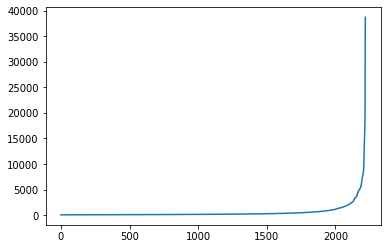

In [147]:
go_counts = Counter()
for go_ids in exp_dict.values():
    go_counts.update(go_ids)
plt.plot(sorted(list(go_counts.values())))
print(len(go_counts))